<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/nyc_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-duration_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-duration_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-durationsample_submission.csv')

# datetime 데이터 전처리(pd.to_datetime)

In [11]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [12]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].dt.day
train['dropoff_hour'] = train['dropoff_datetime'].dt.hour
train['dropoff_weekday'] = train['dropoff_datetime'].dt.weekday

In [14]:
# folium하기 위한 전처리
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_weekday,dropoff_date,dropoff_day,dropoff_hour,dropoff_weekday,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,0,2016-03-14,14,17,0,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,6,2016-06-12,12,0,6,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,1,2016-01-19,19,12,1,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,2,2016-04-06,6,19,2,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,5,2016-03-26,26,13,5,40.793,-73.973,40.783,-73.973


# PCA
우리는 경도와 위도 좌표를 변환하기 위해 PCA를 사용한다.
이 경우 2D-> 2D를 변환하기 때문에 차원 축소에 대한 것이 아니다. 
회전(rotation)은 의사 결정 트리 분할에 도움이 될 수 있다.

In [15]:
from sklearn.decomposition import PCA

coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']],
                    train[['dropoff_latitude', 'dropoff_longitude']],
                    test[['pickup_latitude', 'pickup_longitude']],
                    test[['dropoff_latitude', 'dropoff_longitude']]))

pca = PCA().fit(coords)

In [21]:
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:,0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:,1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:,0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:,1]

test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:,0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:,1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:,0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:,1]

(-0.134261866977465, 0.1017816834266389)

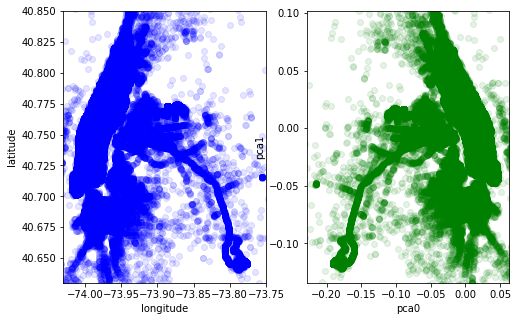

In [25]:
# pca 시각화
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols=2, figsize=(8,5))
ax[0].scatter(train['pickup_longitude_round3'], train['pickup_latitude_round3'], color='blue', alpha=0.1)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)

ax[1].scatter(train['pickup_pca0'], train['pickup_pca1'], color='green', alpha=0.1)
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
pca_borders = pca.transform([[x,y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:,0].min(), pca_borders[:,0].max())
ax[1].set_ylim(pca_borders[:,1].min(), pca_borders[:,1].max())


In [29]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))